In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [4]:
DATA_ROOT = Path('..') / 'data'

dfs = []
activity_labels = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activity_labels[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    
    # Add a column indicating order of the activities for a particiapnt.
    df = df.sort_values(by=['time'])
    df['activity_sequence'] = (df['activity'].shift(1) != df['activity']).cumsum()
    dfs.append(df)

sensor_df = pd.concat(dfs, axis='index')
sensor_df = sensor_df.sort_values(by=['participant', 'time'])

sensor_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1,bed,M,d1p01M,1


### We need to get the length of consecutive sequences for each participant

#### Let's start with a single participant first!

In [5]:
mini = sensor_df[sensor_df['participant'] == 'd1p01M']

In [6]:
mini

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant,activity_sequence
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.42520,924.25,1,bed,M,d1p01M,1
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.73690,921.75,1,bed,M,d1p01M,1
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.03110,923.75,1,bed,M,d1p01M,1
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.03710,921.25,1,bed,M,d1p01M,1
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.89200,920.25,1,bed,M,d1p01M,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,251.00,0.87003,0.46851,0.009122,4,-58.5,0.73631,921.75,1,bed,M,d1p01M,9
397,251.25,0.87003,0.46851,0.009122,1,-57.5,0.70870,923.25,1,bed,M,d1p01M,9
398,251.50,0.87003,0.46851,0.009122,1,-59.0,0.25157,924.75,1,bed,M,d1p01M,9
399,253.25,-0.00938,0.95081,-0.116310,1,-58.5,0.35282,924.25,1,bed,M,d1p01M,9


#### function to count data point in each sequence for a single participant

In [47]:
def count_datapoints(part):
    '''takes a dataframe and returns the number of datapoints, duration and sampling ratio for each type 
    of sequence. Code for grouping consecutive values into sequences adapted from here https://tinyurl.com/y6gab5fh'''
    
    p_data = []

    for _, v in part.groupby((part['activity'].shift() != part['activity']).cumsum()):
        
        activity = v.activity.unique()[0]
        no_meas = len(v)
        dur = round(v.time.iloc[-1] - v.time.iloc[0], 3)
        if dur == 0.0:
            s_ratio = 0
        else:
            s_ratio = no_meas/dur
        
        p_data.append([activity, no_meas, dur, s_ratio ])
        
    p_df = pd.DataFrame(p_data, columns = ['activity_type', 'number_of_measurements', 'duration', 'sampling_ratio'])
        
    return p_df

In [48]:
p = count_datapoints(mini)

In [49]:
p.head()

,activity_type,number_of_measurements,duration,sampling_ratio
0,1,55,37.00,1.486486
1,3,117,36.50,3.205479
2,1,47,27.25,1.724771
3,4,4,7.50,0.533333
4,2,60,77.00,0.779221


#### now let's apply this to *all participants*

In [50]:
seq_df = sensor_df.groupby('participant').apply(count_datapoints).reset_index().drop(['level_1'], axis=1)

In [51]:
seq_df.head()

,participant,activity_type,number_of_measurements,duration,sampling_ratio
0,d1p01M,1,55,37.00,1.486486
1,d1p01M,3,117,36.50,3.205479
2,d1p01M,1,47,27.25,1.724771
3,d1p01M,4,4,7.50,0.533333
4,d1p01M,2,60,77.00,0.779221


#### How many sequences do we have to work with? 

In [52]:
seq_df.shape

(700, 5)

#### How many sequences for each activity type? 

In [53]:
seq_df.activity_type.value_counts()

1    233
4    230
3    157
2     80
Name: activity_type, dtype: int64

#### How many have only one sample point, and how many of those in each activity? 

In [54]:
print('single data point sequences:', len(seq_df.loc[seq_df['duration'] == 0.00]))
seq_df.loc[seq_df['duration'] == 0.00].activity_type.value_counts()

single data point sequences: 68


4    42
1    12
2    11
3     3
Name: activity_type, dtype: int64

### Quickest way to get a sense of what's going on with the data is still by plotting

What's the distribution of counts of sequences for all participants? 

In [55]:
part_s = seq_df.groupby('participant').describe()

In [56]:
part_s

activity_type                                                \
                    count      mean       std  min  25%  50%   75%  max   
participant                                                               
d1p01M                9.0  2.222222  1.301708  1.0  1.0  2.0  3.00  4.0   
d1p02M               11.0  2.545455  1.368476  1.0  1.0  3.0  4.00  4.0   
d1p03M                8.0  2.375000  1.302470  1.0  1.0  2.5  3.25  4.0   
d1p04M               10.0  2.400000  1.349897  1.0  1.0  2.5  3.75  4.0   
d1p05M               11.0  2.545455  1.368476  1.0  1.0  3.0  4.00  4.0   
...                   ...       ...       ...  ...  ...  ...   ...  ...   
d2p23F                9.0  2.444444  1.424001  1.0  1.0  3.0  4.00  4.0   
d2p24F               11.0  2.545455  1.368476  1.0  1.0  3.0  4.00  4.0   
d2p25F               11.0  2.545455  1.368476  1.0  1.0  3.0  4.00  4.0   
d2p26F               13.0  2.615385  1.325296  1.0  1.0  3.0  4.00  4.0   
d2p27F               12.0  2.500000  1.314257  1.0  1.0  2.5  4.00  4.0   

            number_of_measurements             ... duration          \
                             count       mean  ...      75%     max   
participant                                    ...                    
d1p01M                         9.0  44.555556  ...  37.0000   77.00   
d1p02M                        11.0  23.636364  ...  48.2500   73.00   
d1p03M                         8.0  41.000000  ...  74.5625   84.25   
d1p04M                        10.0  53.100000  ...  56.7000   91.00   
d1p05M                        11.0  45.272727  ...  59.2500   73.50   
...                            ...        ...  ...      ...     ...   
d2p23F                         9.0  22.666667  ...  60.7500  215.75   
d2p24F                        11.0  55.909091  ...  19.5000  226.00   
d2p25F                        11.0  18.363636  ...   9.7500  237.00   
d2p26F                        13.0  17.769231  ...  89.5000  299.00   
d2p27F                        12.0  14.833333  ...  28.2500  116.28   

            sampling_ratio                                                    \
                     count      mean       std       min       25%       50%   
participant                                                                    
d1p01M                 9.0  1.947607  1.361526  0.533333  0.800000  1.724771   
d1p02M                11.0  2.353302  2.410112  0.000000  0.698592  1.346939   
d1p03M                 8.0  1.965747  1.284586  0.321070  0.842999  2.199772   
d1p04M                10.0  2.730860  2.435518  0.000000  1.372254  2.017378   
d1p05M                11.0  2.523091  2.231286  0.000000  0.678471  2.500000   
...                    ...       ...       ...       ...       ...       ...   
d2p23F                 9.0  1.063079  0.998200  0.000000  0.098765  0.869565   
d2p24F                11.0  1.522273  0.943526  0.190476  0.845588  1.571429   
d2p25F                11.0  1.570717  1.303196  0.000000  0.424284  1.818182   
d2p26F                13.0  1.130741  1.105195  0.000000  0.317726  0.933333   
d2p27F                12.0  1.965061  2.021224  0.085511  0.697264  1.394958   

                                 
                  75%       max  
participant                      
d1p01M       2.179894  4.819277  
d1p02M       3.333333  8.000000  
d1p03M       2.514286  4.000000  
d1p04M       3.519231  8.000000  
d1p05M       3.652174  7.000000  
...               ...       ...  
d2p23F       1.616725  3.000000  
d2p24F       2.125533  3.040000  
d2p25F       2.387150  4.000000  
d2p26F       1.555556  3.333333  
d2p27F       2.249907  7.333333  

[87 rows x 32 columns]

#### Get an idea of the distribution of numbers of sequences in all particpants


<AxesSubplot:>

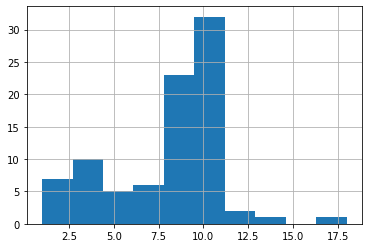

In [57]:
part_s['activity_type']['count'].hist()

### Get a histogram of number of measurements, durations & sampling_rate for types of activity

reminder: activity_labels = ['bed', 'chair', 'lying', 'ambulating']

<AxesSubplot:>

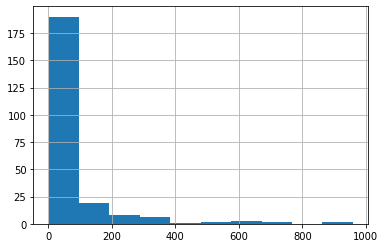

In [58]:
seq_df[seq_df['activity_type'] == 1]['number_of_measurements'].hist()

<AxesSubplot:>

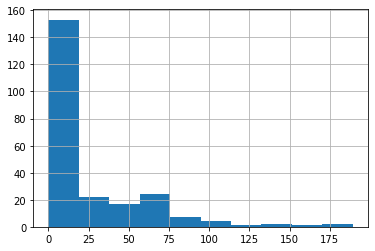

In [59]:
seq_df[seq_df['activity_type'] == 1]['duration'].hist()

<AxesSubplot:>

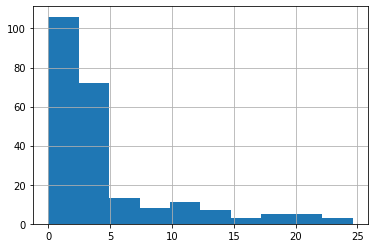

In [60]:
seq_df[seq_df['activity_type'] == 1]['sampling_ratio'].hist()

#### Descriptives by activity type

In [61]:
a_desc = seq_df.groupby('activity_type').describe()

a_desc

number_of_measurements                                     \
                               count        mean         std  min   25%   
activity_type                                                             
1                              233.0   70.412017  149.913660  1.0   4.0   
2                               80.0   61.387500   97.774928  1.0   7.0   
3                              157.0  328.152866  426.620773  1.0  58.0   
4                              230.0    9.960870   14.449528  1.0   2.0   

                                    duration              ...            \
                 50%    75%     max    count        mean  ...       75%   
activity_type                                             ...             
1               10.0   62.0   959.0    233.0   22.972189  ...   37.0000   
2               32.5   69.5   624.0     80.0   73.903500  ...   98.6250   
3              162.0  423.0  2270.0    157.0  100.343153  ...  122.7500   
4                5.0   10.0   108.0    230.0    4.211891  ...    4.7725   

                      sampling_ratio                                     \
                  max          count      mean       std  min       25%   
activity_type                                                             
1              189.25          233.0  4.471911  5.204891  0.0  1.578692   
2              299.00           80.0  0.867050  1.176058  0.0  0.201465   
3              329.25          157.0  3.427634  4.393860  0.0  0.821053   
4              237.00          230.0  4.283232  6.380587  0.0  0.800000   

                                              
                    50%       75%        max  
activity_type                                 
1              2.666667  4.000000  24.615385  
2              0.510216  0.891619   7.090909  
3              2.153132  3.603960  22.194922  
4              1.809091  4.000000  40.000000  

[4 rows x 24 columns]

#### Descriptives for activity type by participant

In [62]:
pa_desc = seq_df.groupby(['participant', 'activity_type']).describe().reset_index()

pa_desc

participant activity_type number_of_measurements                     \
                                               count    mean        std   
0        d1p01M             1                    4.0   28.50  26.236107   
1        d1p01M             2                    1.0   60.00        NaN   
2        d1p01M             3                    2.0  110.00   9.899495   
3        d1p01M             4                    2.0    3.50   0.707107   
4        d1p02M             1                    4.0   19.00  19.061305   
..          ...           ...                    ...     ...        ...   
309      d2p26F             4                    5.0    5.60   5.176872   
310      d2p27F             1                    4.0   10.50   6.027714   
311      d2p27F             2                    2.0   38.50   9.192388   
312      d2p27F             3                    2.0   10.00   1.414214   
313      d2p27F             4                    4.0    9.75   5.852350   

                                          ...   duration          \
       min     25%    50%     75%    max  ...        75%     max   
0      4.0    7.00   27.5   49.00   55.0  ...   29.68750   37.00   
1     60.0   60.00   60.0   60.00   60.0  ...   77.00000   77.00   
2    103.0  106.50  110.0  113.50  117.0  ...   44.56250   47.25   
3      3.0    3.25    3.5    3.75    4.0  ...    6.56250    7.50   
4      2.0    2.75   19.0   35.25   36.0  ...   38.43750   60.75   
..     ...     ...    ...     ...    ...  ...        ...     ...   
309    1.0    3.00    3.0    7.00   14.0  ...    7.50000    9.00   
310    4.0    6.25   10.5   14.75   17.0  ...    6.55625    7.25   
311   32.0   35.25   38.5   41.75   45.0  ...  107.77250  116.28   
312    9.0    9.50   10.0   10.50   11.0  ...   79.31250  105.25   
313    3.0    6.75    9.5   12.50   17.0  ...    8.62250   10.25   

    sampling_ratio                                                    \
             count      mean       std       min       25%       50%   
0              4.0  2.507634  1.555314  1.486486  1.665200  1.862385   
1              1.0  0.779221       NaN  0.779221  0.779221  0.779221   
2              2.0  2.692687  0.725198  2.179894  2.436290  2.692687   
3              2.0  0.666667  0.188562  0.533333  0.600000  0.666667   
4              4.0  2.101022  1.542126  0.576132  1.015001  1.913978   
..             ...       ...       ...       ...       ...       ...   
309            5.0  0.983492  0.812135  0.000000  0.428571  0.933333   
310            4.0  1.766460  0.779777  0.800000  1.435294  1.789047   
311            2.0  0.388027  0.001457  0.386997  0.387512  0.388027   
312            2.0  3.709422  5.124985  0.085511  1.897466  3.709422   
313            4.0  2.079997  1.363686  1.073171  1.125436  1.623409   

                         
          75%       max  
0    2.704819  4.819277  
1    0.779221  0.779221  
2    2.949083  3.205479  
3    0.733333  0.800000  
4    3.000000  4.000000  
..        ...       ...  
309  1.555556  2.000000  
310  2.120213  2.687747  
311  0.388543  0.389058  
312  5.521378  7.333333  
313  2.577970  4.000000  

[314 rows x 26 columns]